In [1]:
# Setup

import math
import numpy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List
from sklearn.datasets import fetch_openml

# Loading MNIST dataset

mnist = fetch_openml(name='mnist_784', version=1)

images, labels = mnist.data, mnist.target

IMAGE_DIM: int = 28
DIGITS = 10

WRONG_ANSWER_VAL = 0
RIGHT_ANSWER_VAL = 1

def get_output_for_digit(digit: int) -> np.ndarray:
    arr = [WRONG_ANSWER_VAL for i in range(0, DIGITS)]
    arr[digit] = RIGHT_ANSWER_VAL
    return arr

def get_correct_digit(index: int) -> int:
    return int(labels[index])

def get_output_for_index(index: int) -> np.ndarray:
    return get_output_for_digit(get_correct_digit(index))

TOTAL_TRAINING_CASES = 70000
MAX_VAL = 256

datas = []
for i in range(0, TOTAL_TRAINING_CASES):
    datas.append(([v / MAX_VAL for v in images.iloc[i].values], get_output_for_digit(get_correct_digit(i))))


In [2]:
def rec_sigmoid(z):
  return np.tanh(z)

def rec_sigmoid_prime(z):
  return np.diag(1 - np.power(np.tanh(z), 2))

class RecursiveNeuralNetwork:

    layer_dimensions: List[int] = []
    inner_layers: int = 0
    learning_rate: float = 0

    weights: List[np.ndarray] = []
    biases: List[np.ndarray] = []

    def __init__(self, layer_dimensions: List[int], learning_rate: float):
        self.layer_dimensions = layer_dimensions
        self.inner_layers = len(layer_dimensions) - 1
        self.learning_rate = learning_rate

        self.randomize_parameters()
    
    def get_layer_dimension(self, dimension: int) -> int:

        return self.layer_dimensions[dimension]

    def randomize_parameters(self):
        
        self.weights = []
        self.biases = []

        for layer in range(1, self.inner_layers+1):

            last_dim = self.get_layer_dimension(layer - 1)
            this_dim = self.get_layer_dimension(layer)

            self.weights.append(np.random.rand(this_dim, last_dim))
            self.biases.append(np.random.rand(this_dim))

    def run(self, input: List[int]) -> List[int]:
        acc = input
        for layer in range(0, self.inner_layers):
            acc = rec_sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc
    
    def run_to_layer(self, input: List[int], to_layer: int) -> List[int]:
        assert(to_layer <= self.inner_layers)
        acc = input
        for layer in range(0, to_layer):
            acc = rec_sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc

    def get_cost(self, inputs: List[int], expected_output: List[int]) -> float:
        return 0.5 * np.linalg.norm(self.run(inputs) - expected_output) ** 2

    # todo make these more efficient

    def train(self, input: List[int], expected_output: List[int]):
        bias_gradients: List[np.ndarray] = []
        weight_gradients: List[np.ndarray] = []

        for layer in range(0, self.inner_layers):
            bias_gradients.append(self.get_cost_gradient_bias(input, expected_output, layer))
            weight_gradients.append(self.get_cost_gradient_weight(input, expected_output, layer))
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= self.learning_rate * bias_gradients[layer]
            self.weights[layer] -= self.learning_rate * weight_gradients[layer]

    def get_cost_gradient_bias(self, input: List[int], expected_output: List[int], target_layer: int) -> np.ndarray:
        return self.__rec_gradient_helper(input, self.inner_layers-1, target_layer) @ (self.rec_run_helper(input, self.inner_layers-1, 0) - expected_output)

    def get_cost_gradient_weight(self, input: List[int], expected_output: List[int], target_layer: int) -> np.ndarray:
        return np.outer(self.__rec_gradient_helper(input, self.inner_layers-1, target_layer) @ (self.rec_run_helper(input, self.inner_layers-1, 0) - expected_output), self.rec_run_helper(input, target_layer-1, 0))

    def __rec_gradient_helper(self, input: List[int], current_layer: int, target_layer: int) -> np.ndarray:
        if current_layer == target_layer:
            return rec_sigmoid_prime(self.weights[current_layer] @ self.rec_run_helper(input, current_layer-1, 0) + self.biases[current_layer])
        else:
            return self.__rec_gradient_helper(input, current_layer-1, target_layer) @ self.weights[current_layer].transpose() @ rec_sigmoid_prime(self.weights[current_layer] @ self.rec_run_helper(input, current_layer-1, 0) + self.biases[current_layer])
        
    def rec_run_helper(self, input: List[int], current_layer: int, target_layer: int) -> np.ndarray:
        if current_layer == target_layer - 1:
            return input
        else:
            return rec_sigmoid(self.weights[current_layer] @ self.rec_run_helper(input, current_layer-1, target_layer) + self.biases[current_layer])


In [3]:
def iter_sigmoid(z):
  return np.tanh(z)

def iter_sigmoid_prime(z):
  return 1 - np.power(np.tanh(z), 2)

class IterativeNeuralNetwork:

    layer_dimensions: List[int] = []
    inner_layers: int = 0
    learning_rate: float = 0

    weights: List[np.ndarray] = []
    biases: List[np.ndarray] = []

    def __init__(self, layer_dimensions: List[int], learning_rate: float):
        self.layer_dimensions = layer_dimensions
        self.inner_layers = len(layer_dimensions) - 1
        self.learning_rate = learning_rate

        self.randomize_parameters()
    
    def get_layer_dimension(self, dimension: int) -> int:

        return self.layer_dimensions[dimension]

    def randomize_parameters(self):
        
        self.weights = []
        self.biases = []

        for layer in range(1, self.inner_layers+1):

            last_dim = self.get_layer_dimension(layer - 1)
            this_dim = self.get_layer_dimension(layer)

            self.weights.append(np.random.randn(this_dim, last_dim))
            self.biases.append(np.random.randn(this_dim))

    def run(self, input: List[int]) -> List[int]:
        acc = input
        for layer in range(0, self.inner_layers):
            acc = iter_sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc
    
    def run_to_layer(self, input: List[int], to_layer: int) -> List[int]:
        assert(to_layer <= self.inner_layers)
        acc = input
        for layer in range(0, to_layer):
            acc = iter_sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc

    def get_cost(self, inputs: List[int], expected_output: List[int]) -> float:
        return 0.5 * np.linalg.norm(self.run(inputs) - expected_output) ** 2

    def get_gradients_for(self, input: List[int], expected_output: List[int]) -> tuple[List[np.ndarray], List[np.ndarray]]:
        # forward propagation
        activations = []
        activation_primes = []
        acc = input
        for layer in range(0, self.inner_layers):
            activations.append(acc)

            mult = self.weights[layer] @ acc + self.biases[layer]
            acc = iter_sigmoid(mult)
            activation_primes.append(iter_sigmoid_prime(mult))
            
        activations.append(acc)

        residuals = activations[-1] - expected_output

        bias_gradients: List[np.ndarray] = [None] * self.inner_layers
        weight_gradients: List[np.ndarray] = [None] * self.inner_layers
        
        acc = residuals * activation_primes[self.inner_layers-1]
        for layer in range(self.inner_layers-1, -1, -1):

            bias_gradients[layer] = acc
            weight_gradients[layer] = np.outer(acc, activations[layer])

            if layer != 0: 
                acc = activation_primes[layer-1] * (self.weights[layer].transpose() @ acc)

        return (bias_gradients, weight_gradients)

    def train(self, input: List[int], expected_output: List[int]):

        gradients = self.get_gradients_for(input, expected_output)
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= self.learning_rate * gradients[0][layer]
            self.weights[layer] -= self.learning_rate * gradients[1][layer]
    
    def train_batch(self, inputs: List[List[float]], expected_outputs: List[List[float]]):
        batch_size = len(inputs)
        
        total_bias_gradients = [None] * self.inner_layers
        total_weight_gradients = [None] * self.inner_layers
        for i in range(0, batch_size):

            gradients = self.get_gradients_for(inputs[i], expected_outputs[i])
            
            if i == 0:
                total_bias_gradients = gradients[0]
                total_weight_gradients = gradients[1]
            else:
                for j in range(0, self.inner_layers):
                    total_bias_gradients[j] += gradients[0][j]
                    total_weight_gradients[j] += gradients[1][j]

        for i in range(0, self.inner_layers):        
            total_bias_gradients[i] *= self.learning_rate / batch_size
            total_weight_gradients[i] *= self.learning_rate / batch_size
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= total_bias_gradients[layer]
            self.weights[layer] -= total_weight_gradients[layer]


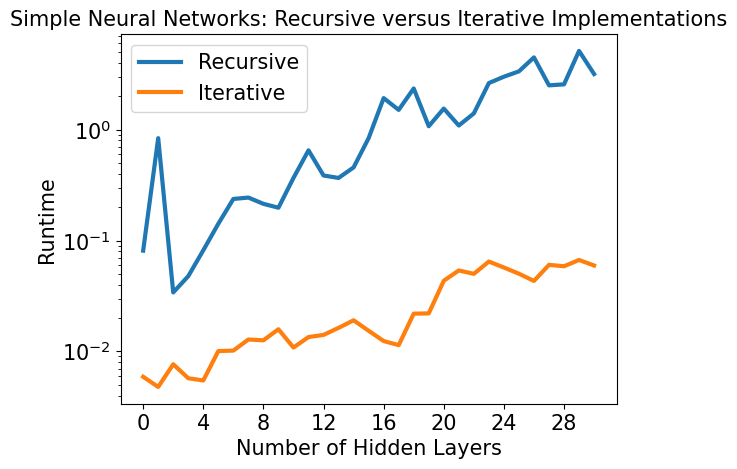

In [4]:
# Time training against the first 100 digits of the MNIST dataset.
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

LAYERS = range(0, 31)
TEST_COUNT = 10

# Trials for the recursive method
recursive_times = np.zeros(len(LAYERS))

for i in range(len(LAYERS)):
    start_time = time.time()

    layers = [IMAGE_DIM*IMAGE_DIM]
    layers += [16]*LAYERS[i]
    layers += [DIGITS]

    network = RecursiveNeuralNetwork(layers, 0.1)

    for j in range(0, TEST_COUNT):
        network.train(datas[j][0], datas[j][1])

    end_time = time.time()

    recursive_times[i] = end_time - start_time

# Trials for the iterative method
iterative_times = np.zeros(len(LAYERS))

for i in range(len(LAYERS)):
    start_time = time.time()

    layers = [IMAGE_DIM*IMAGE_DIM]
    layers += [16]*LAYERS[i]
    layers += [DIGITS]

    network = IterativeNeuralNetwork(layers, 0.1)

    for j in range(0, TEST_COUNT):
        batch_in = [d[0] for d in datas[i:i+1]]
        batch_out = [d[1] for d in datas[i:i+1]]
        network.train_batch(batch_in, batch_out)

    end_time = time.time()

    iterative_times[i] = end_time - start_time

plt.plot(LAYERS, recursive_times, label='Recursive', linewidth=3)
plt.plot(LAYERS, iterative_times, label='Iterative', linewidth=3)
plt.xlabel('Number of Hidden Layers', fontsize=15)
plt.ylabel('Runtime', fontsize=15)
plt.title('Simple Neural Networks: Recursive versus Iterative Implementations', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
# Set x-axis ticks to integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()